🧩 A. FrozenLake-v1 – Tabular Q-Learning

1️⃣ Setup & Inisialisasi

In [28]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("FrozenLake-v1", is_slippery=False)  # Tidak licin (lebih deterministik)
n_states = env.observation_space.n
n_actions = env.action_space.n

Q = np.zeros((n_states, n_actions))

alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

n_episodes = 2000
max_steps = 100
rewards_per_episode = []

2️⃣ Training Loop

In [33]:
for episode in range(n_episodes):
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    total_reward = 0

    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_state, reward, done, _ = env.step(action)
        if done:
          break

        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        state = next_state
        total_reward += reward

        if done:
            break

    rewards_per_episode.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if (episode + 1) % 100 == 0:
        avg = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode+1}, avg reward (100): {avg:.2f}, epsilon: {epsilon:.3f}")

Episode 100, avg reward (100): 0.00, epsilon: 0.606
Episode 200, avg reward (100): 0.00, epsilon: 0.367
Episode 300, avg reward (100): 0.00, epsilon: 0.222
Episode 400, avg reward (100): 0.00, epsilon: 0.135
Episode 500, avg reward (100): 0.00, epsilon: 0.082
Episode 600, avg reward (100): 0.00, epsilon: 0.050
Episode 700, avg reward (100): 0.00, epsilon: 0.050
Episode 800, avg reward (100): 0.00, epsilon: 0.050
Episode 900, avg reward (100): 0.00, epsilon: 0.050
Episode 1000, avg reward (100): 0.00, epsilon: 0.050
Episode 1100, avg reward (100): 0.00, epsilon: 0.050
Episode 1200, avg reward (100): 0.00, epsilon: 0.050
Episode 1300, avg reward (100): 0.00, epsilon: 0.050
Episode 1400, avg reward (100): 0.00, epsilon: 0.050
Episode 1500, avg reward (100): 0.00, epsilon: 0.050
Episode 1600, avg reward (100): 0.00, epsilon: 0.050
Episode 1700, avg reward (100): 0.00, epsilon: 0.050
Episode 1800, avg reward (100): 0.00, epsilon: 0.050
Episode 1900, avg reward (100): 0.00, epsilon: 0.050
Ep

3️⃣ Evaluasi Agen

In [36]:
print("\n=== Evaluasi Agen ===")
wins = 0
for _ in range(100):
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, done, _ = env.step(action)
        if done:
            break
        state = next_state
        if done:
            wins += reward
            break

print(f"Akurasi menang: {wins}%")


=== Evaluasi Agen ===
Akurasi menang: 0%


4️⃣ Visualisasi Hasil

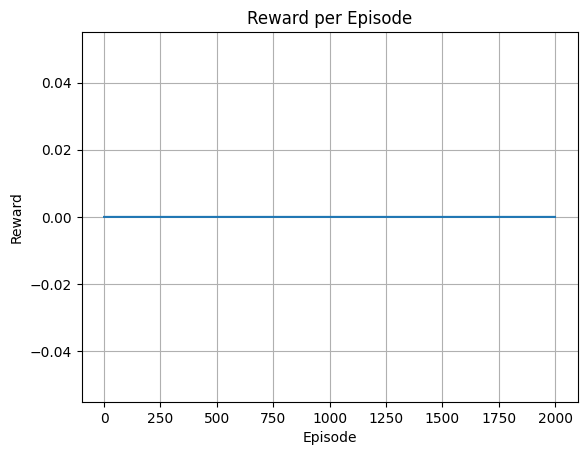

In [37]:
plt.plot(rewards_per_episode)
plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

🎮 B. CartPole-v1 – Deep Q-Network (DQN)

1️⃣ Setup & Q-Network

In [38]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random

env = gym.make("CartPole-v1", render_mode=None)
obs_shape = env.observation_space.shape[0]
n_actions = env.action_space.n

def build_q_model():
    return keras.Sequential([
        keras.layers.Dense(32, activation="relu", input_shape=[obs_shape]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(n_actions)
    ])

model = build_q_model()
target_model = build_q_model()
target_model.set_weights(model.get_weights())

2️⃣ Replay Buffer & Sampling

In [39]:
replay_buffer = deque(maxlen=2000)
batch_size = 64

def sample_experience():
    minibatch = random.sample(replay_buffer, batch_size)
    states = np.array([exp[0] for exp in minibatch], dtype=np.float32)
    actions = np.array([exp[1] for exp in minibatch])
    rewards = np.array([exp[2] for exp in minibatch])
    next_states = np.array([exp[3] for exp in minibatch], dtype=np.float32)
    dones = np.array([exp[4] for exp in minibatch], dtype=np.float32)
    return states, actions, rewards, next_states, dones

3️⃣ Hyperparameters

In [40]:
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.MeanSquaredError()

4️⃣ Training Loop

In [43]:
n_episodes = 300

for episode in range(n_episodes):
    reset_result = env.reset()
    state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
    total_reward = 0

    for step in range(200):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(state.reshape(1, -1), verbose=0)
            action = np.argmax(q_values[0])

        next_state, reward, done, _ = env.step(action)
        if done:
            break
        total_reward += reward

        replay_buffer.append((
            np.array(state, dtype=np.float32),
            action,
            reward,
            np.array(next_state, dtype=np.float32),
            done
        ))

        state = next_state

        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = sample_experience()
            next_qs = target_model.predict(next_states, verbose=0)
            max_next_q = np.max(next_qs, axis=1)
            target_q = rewards + (1 - dones) * gamma * max_next_q

            masks = tf.one_hot(actions, n_actions)

            with tf.GradientTape() as tape:
                all_qs = model(states)
                selected_q = tf.reduce_sum(all_qs * masks, axis=1)
                loss = loss_fn(target_q, selected_q)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if done:
            break

    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode+1}, Reward: {total_reward:.0f}, Epsilon: {epsilon:.3f}")

Episode 1, Reward: 19, Epsilon: 0.995
Episode 2, Reward: 9, Epsilon: 0.990
Episode 3, Reward: 19, Epsilon: 0.985
Episode 4, Reward: 21, Epsilon: 0.980
Episode 5, Reward: 31, Epsilon: 0.975
Episode 6, Reward: 15, Epsilon: 0.970
Episode 7, Reward: 11, Epsilon: 0.966
Episode 8, Reward: 14, Epsilon: 0.961
Episode 9, Reward: 46, Epsilon: 0.956
Episode 10, Reward: 10, Epsilon: 0.951
Episode 11, Reward: 12, Epsilon: 0.946
Episode 12, Reward: 27, Epsilon: 0.942
Episode 13, Reward: 25, Epsilon: 0.937
Episode 14, Reward: 12, Epsilon: 0.932
Episode 15, Reward: 8, Epsilon: 0.928
Episode 16, Reward: 20, Epsilon: 0.923
Episode 17, Reward: 16, Epsilon: 0.918
Episode 18, Reward: 25, Epsilon: 0.914
Episode 19, Reward: 8, Epsilon: 0.909
Episode 20, Reward: 36, Epsilon: 0.905
Episode 21, Reward: 20, Epsilon: 0.900
Episode 22, Reward: 10, Epsilon: 0.896
Episode 23, Reward: 50, Epsilon: 0.891
Episode 24, Reward: 13, Epsilon: 0.887
Episode 25, Reward: 7, Epsilon: 0.882
Episode 26, Reward: 25, Epsilon: 0.878

5️⃣ Evaluasi Akhir

In [45]:
print("\n=== EVALUASI ===")
reset_result = env.reset()
state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
done = False
total_reward = 0

while not done:
    env.render()
    q_values = model.predict(state.reshape(1, -1), verbose=0)
    action = np.argmax(q_values[0])
    next_state, reward, done, _ = env.step(action)
    if done:
            break
    total_reward += reward

print("Total reward evaluasi:", total_reward)
env.close()


=== EVALUASI ===
Total reward evaluasi: 9.0
